In [1]:
import matplotlib.pyplot as plt
import cv2
import yaml
from os.path import join
import pandas as pd
import numpy as np

In [ ]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

train_dir = config['paths']['train_data']
test_dir = config['paths']['test_data']
data = config['paths']['data_csv']
fig_path = config['paths']['figure']
model_path = config['paths']['model']

In [3]:
pix_train_df = pd.read_csv(join(data, 'training_set_pixel_size_and_HC.csv'))
pix_test_df = pd.read_csv(join(data, 'test_set_pixel_size.csv'))

# Fill-in mask


In [4]:
def fill_in (img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(imgray, 127, 255, 0)
    contours,_ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(img, ellipse, (255,255,255), -1)

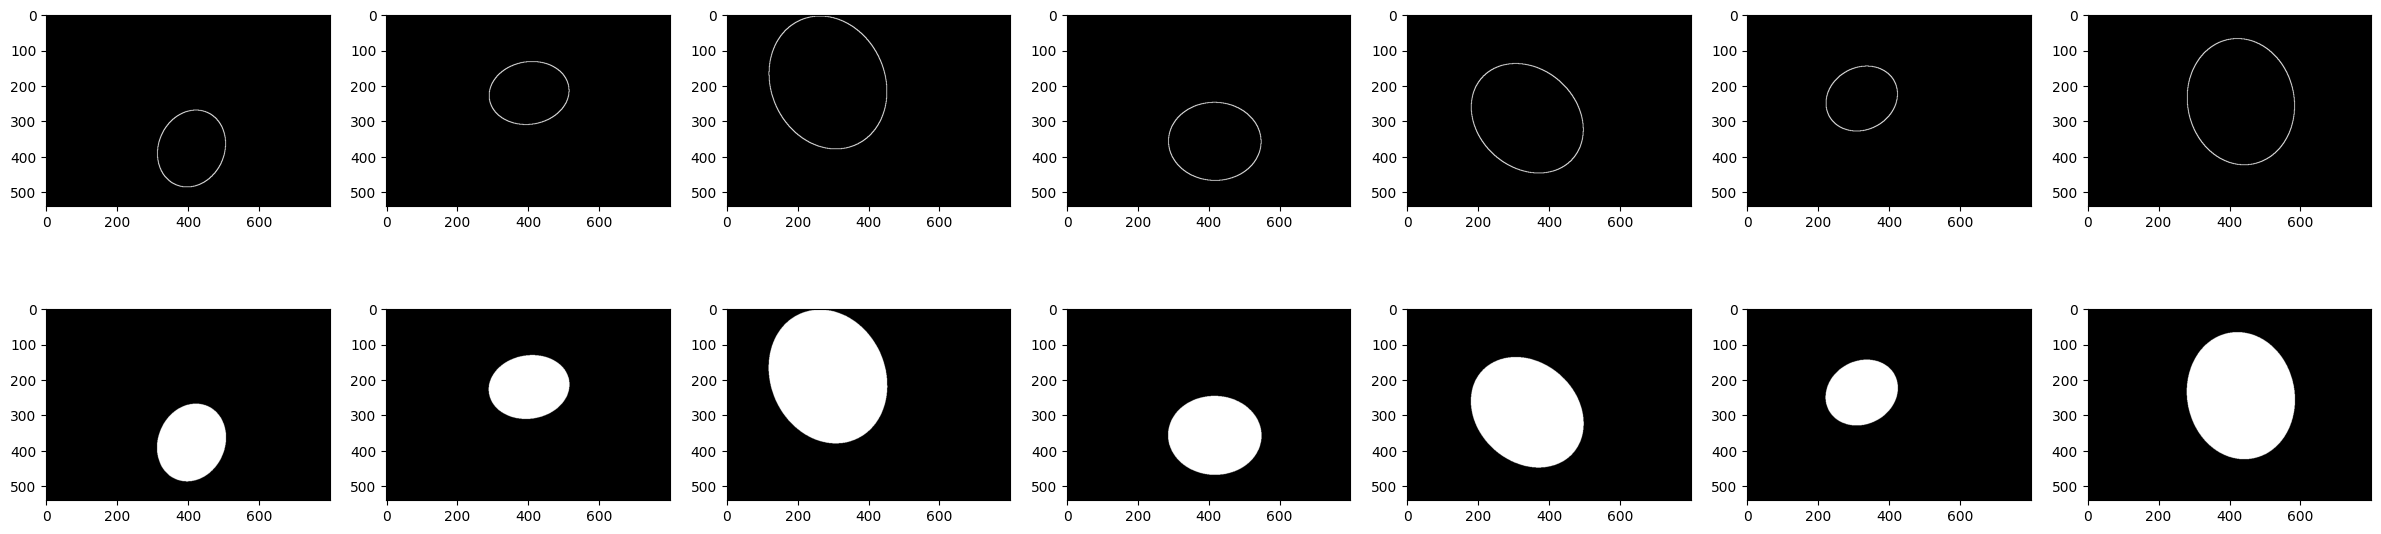

In [5]:
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = join(train_dir, pix_train_df.iloc[index, 0].replace('.png','_Annotation.png'))

  ax = fig.add_subplot(2, 7, index + 1)
  plt.imshow(cv2.imread(file_path))

  ax = fig.add_subplot(2, 7, index + 8)
  plt.imshow(fill_in(cv2.imread(file_path)))

plt.savefig(join(fig_path, 'Fill-in Mask.png'))

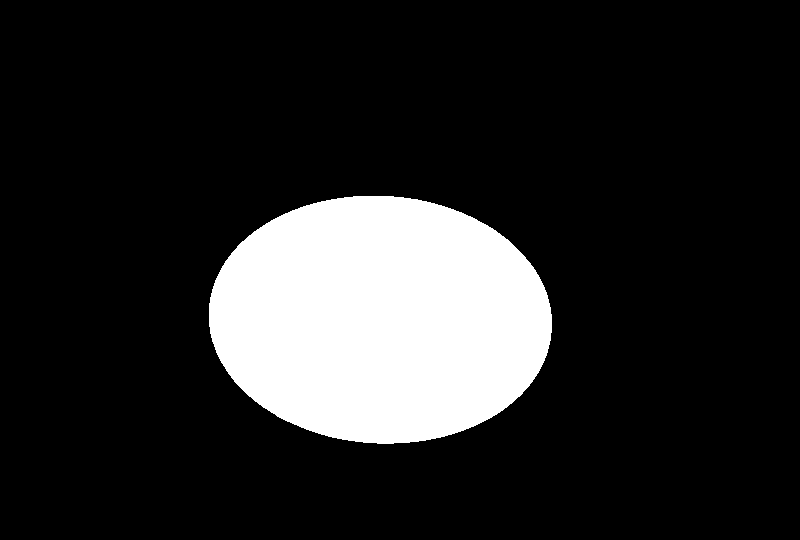

In [6]:
import PIL.Image as p

img = join(train_dir, '388_HC_Annotation.png')
mask = fill_in (cv2.imread(img))
mask = p.fromarray(mask)

display(mask)
mask.save(join(fig_path, '388_HC_Mask.png'))

In [7]:
mask_dir = config['paths']['train_mask']

for index in range(len(pix_train_df)):
    file_name = pix_train_df.iloc[index, 0].replace('.png', '_Annotation.png')
    file_path = join(train_dir, file_name)

    image = cv2.imread(file_path)

    mask = fill_in(image)

    name_mask = file_name.replace('_Annotation.png', '_Mask.png')
    output_path = join(mask_dir, name_mask)

    cv2.imwrite(output_path, mask)

In [8]:
import os

num_files = len([f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))])
print(f"Number of samples in mask_dir: {num_files}")

Number of samples in mask_dir: 999


In [9]:
print(mask_dir)

D:/Workspace/Machine_Learning/mlmed2025/Practice_2_HCI18_Regression/data/training_mask


# Data Loader

In [ ]:
import glob

class HC18Dataset:
    def __init__(self, img_dir, mask_dir, img_size=(256, 256)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = tuple(img_size)
        self.image_paths, self.mask_paths = self._load_image_mask_paths()

    def _load_image_mask_paths(self):
        image_paths = sorted(glob.glob(os.path.join(self.img_dir, "*HC.png")))
        mask_paths = sorted(glob.glob(os.path.join(self.mask_dir, "*.png")))
        return image_paths, mask_paths

    def load_data(self):
        images, masks = [], []
        for img_path, mask_path in zip(self.image_paths, self.mask_paths):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, (self.img_size[1], self.img_size[0])) / 255.0
            mask = cv2.resize(mask, (self.img_size[1], self.img_size[0])) / 255.0

            images.append(img[..., np.newaxis])
            masks.append(mask[..., np.newaxis])

        return np.array(images), np.array(masks)


# U-net model

In [ ]:
from tensorflow.keras import layers, models, losses, metrics, callbacks

class UNet:
    def __init__(self, input_shape=(256, 256, 1)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        inputs = layers.Input(self.input_shape)

        # Encoder
        c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
        c1 = layers.Dropout(0.1)(c1)
        p1 = layers.MaxPooling2D((2, 2))(c1)

        c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
        c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
        c2 = layers.Dropout(0.1)(c2)
        p2 = layers.MaxPooling2D((2, 2))(c2)

        c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
        c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
        c3 = layers.Dropout(0.2)(c3)
        p3 = layers.MaxPooling2D((2, 2))(c3)

        c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
        c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
        c4 = layers.Dropout(0.2)(c4)
        p4 = layers.MaxPooling2D((2, 2))(c4)

        # Bottleneck
        c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
        c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
        c5 = layers.Dropout(0.3)(c5)

        # Decoder
        u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = layers.concatenate([u6, c4])
        c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
        c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
        c6 = layers.Dropout(0.2)(c6)

        u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = layers.concatenate([u7, c3])
        c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
        c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
        c7 = layers.Dropout(0.2)(c7)

        u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = layers.concatenate([u8, c2])
        c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
        c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
        c8 = layers.Dropout(0.1)(c8)

        u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = layers.concatenate([u9, c1])
        c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
        c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
        c9 = layers.Dropout(0.1)(c9)

        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

        return models.Model(inputs, outputs)

    def compile(self, optimize, loss):
        self.model.compile(optimizer=optimize, loss=loss, metrics=[metrics.MeanAbsoluteError()])

    def train(self, X_train, Y_train, X_val, Y_val, epochs, batch_size=32):
        log_dir = "logs/fit"
        tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        checkpoint_callback = callbacks.ModelCheckpoint(join(model_path, "unet_best_model.keras"), save_best_only=True)
        early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        self.model.fit(
            X_train, Y_train,
            validation_data=(X_val, Y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
            )

    def predict(self, X_test):
        return self.model.predict(X_test)

# Data Partitioning

In [ ]:
from sklearn.model_selection import train_test_split

dataset = HC18Dataset(img_dir=train_dir, mask_dir=mask_dir)
X, Y = dataset.load_data()
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Model Training

In [13]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [14]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)

unet = UNet()
unet.compile(optimize=optimizer, loss=dice_loss)

In [15]:
unet.train(X_train, Y_train, X_val, Y_val, epochs=200)

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 382s 10s/step - loss: 0.6141 - mean_absolute_error: 0.5055 - val_loss: 0.5183 - val_mean_absolute_error: 0.6602
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 0.5159 - mean_absolute_error: 0.6397 - val_loss: 0.4871 - val_mean_absolute_error: 0.5578
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.4353 - mean_absolute_error: 0.4593 - val_loss: 0.2204 - val_mean_absolute_error: 0.1419
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 0.2131 - mean_absolute_error: 0.1421 - val_loss: 0.2004 - val_mean_absolute_error: 0.1388
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.1994 - mean_absolute_error: 0.1266 - val_loss: 0.1783 - val_mean_absolute_error: 0.1201
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 0.1651 - mean_absolute_error: 0.1061 - val_loss: 0.1400 - val_mean_absolute_error: 0.0919
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 0.1389 - mean_absolute_error: 0.0871 - val_lo

In [ ]:
def display_learning_curves(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(loss))

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.savefig(join(fig_path, 'Loss_Learning_Curve.png'))
    plt.show()

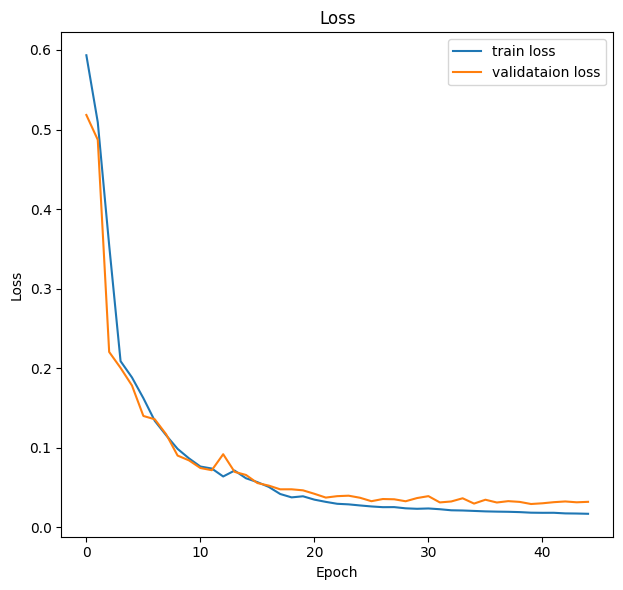

In [17]:
display_learning_curves(unet.model.history)


In [ ]:
def predict_and_show(model, test_image_path, img_size=(256, 256)):

    img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, img_size) / 255.0
    img_resized = np.expand_dims(img_resized, axis=(0, -1))

    pred_mask = model.predict(img_resized)[0, ..., 0]

    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    pred_mask_resized = cv2.resize(pred_mask, (img.shape[1], img.shape[0]))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask_resized, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img, cmap='gray')
    plt.imshow(pred_mask_resized, cmap='jet', alpha=0.5)
    plt.title("Overlay")
    plt.axis("off")

    plt.savefig(join(fig_path, 'predicted_mask.png'))
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


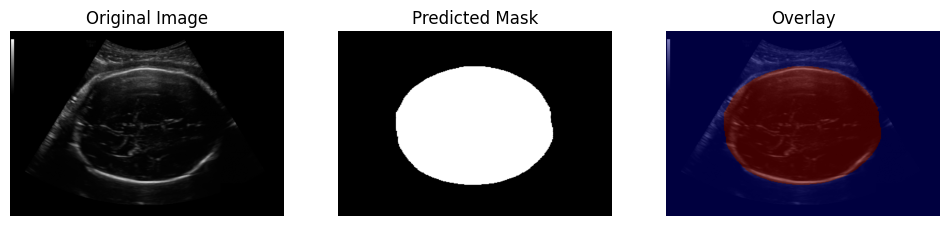

In [ ]:
predict_and_show(unet, join(test_dir, '000_HC.png'))

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def predict_and_save_masks(model, test_folder, save_folder, img_size=(256, 256)):
    os.makedirs(save_folder, exist_ok=True)

    test_images = [f for f in os.listdir(test_folder) if f.endswith('.png')]

    for img_name in tqdm(test_images, desc="Processing images"):
        img_path = os.path.join(test_folder, img_name)
        save_path = os.path.join(save_folder, img_name.replace('.png', '_Annotation.png'))

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img_resized = cv2.resize(img, (img_size[1], img_size[0])) / 255.0
        img_resized = np.expand_dims(img_resized, axis=(0, -1))

        pred_mask = model.predict(img_resized)[0, ..., 0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        pred_mask_resized = cv2.resize(pred_mask, (img.shape[1], img.shape[0]))

        cv2.imwrite(save_path, (pred_mask_resized * 255))

    print(f"Saved all masks to {save_folder}")


In [ ]:
predict_and_save_masks(unet, test_dir, test_dir)

Processing images:   0%|          | 0/335 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:   0%|          | 1/335 [00:00<00:49,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:   1%|          | 2/335 [00:00<00:40,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:   1%|          | 3/335 [00:00<00:39,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:   1%|          | 4/335 [00:00<00:38,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:   1%|▏         | 5/335 [00:00<00:38,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:   2%|▏         | 6/335 [00:00<00:37,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:   2%|▏         | 7/335 [00:00<00:36,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:   2%|▏         | 8/335 [00:00<00:37,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:   3%|▎         | 9/335 [00:01<00:37,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:   3%|▎         | 10/335 [00:01<00:35,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing images:   3%|▎         | 11/335 [00:01<00:34,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:   4%|▎         | 12/335 [00:01<00:34,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing images:   4%|▍         | 13/335 [00:01<00:45,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing images:   4%|▍         | 14/335 [00:01<00:41,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:   4%|▍         | 15/335 [00:01<00:39,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:   5%|▍         | 16/335 [00:01<00:38,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:   5%|▌         | 17/335 [00:02<00:39,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:   5%|▌         | 18/335 [00:02<00:38,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:   6%|▌         | 19/335 [00:02<00:37,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:   6%|▋         | 21/335 [00:02<00:35,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:   7%|▋         | 22/335 [00:02<00:35,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:   7%|▋         | 23/335 [00:02<00:35,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing images:   7%|▋         | 24/335 [00:02<00:34,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing images:   7%|▋         | 25/335 [00:02<00:33,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:   8%|▊         | 26/335 [00:03<00:33,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing images:   8%|▊         | 27/335 [00:03<00:33,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing images:   8%|▊         | 28/335 [00:03<00:33,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:   9%|▊         | 29/335 [00:03<00:33,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Processing images:   9%|▉         | 30/335 [00:03<00:42,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing images:   9%|▉         | 31/335 [00:03<00:41,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing images:  10%|▉         | 32/335 [00:03<00:41,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing images:  10%|▉         | 33/335 [00:03<00:41,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing images:  10%|█         | 34/335 [00:04<00:40,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing images:  10%|█         | 35/335 [00:04<00:39,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing images:  11%|█         | 36/335 [00:04<00:40,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing images:  11%|█         | 37/335 [00:04<00:39,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing images:  11%|█▏        | 38/335 [00:04<00:40,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing images:  12%|█▏        | 39/335 [00:04<00:40,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing images:  12%|█▏        | 40/335 [00:04<00:40,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Processing images:  12%|█▏        | 41/335 [00:05<00:40,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing images:  13%|█▎        | 42/335 [00:05<00:40,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing images:  13%|█▎        | 43/335 [00:05<00:40,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing images:  13%|█▎        | 44/335 [00:05<00:40,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  13%|█▎        | 45/335 [00:05<00:38,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  14%|█▎        | 46/335 [00:05<00:35,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  14%|█▍        | 47/335 [00:05<00:34,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  14%|█▍        | 48/335 [00:05<00:33,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  15%|█▍        | 49/335 [00:06<00:32,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing images:  15%|█▍        | 50/335 [00:06<00:32,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  15%|█▌        | 51/335 [00:06<00:31,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  16%|█▌        | 52/335 [00:06<00:31,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  16%|█▌        | 53/335 [00:06<00:31,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  16%|█▌        | 54/335 [00:06<00:32,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  16%|█▋        | 55/335 [00:06<00:32,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  17%|█▋        | 56/335 [00:06<00:32,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  17%|█▋        | 57/335 [00:06<00:31,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  17%|█▋        | 58/335 [00:07<00:31,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  18%|█▊        | 59/335 [00:07<00:30,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  18%|█▊        | 60/335 [00:07<00:30,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  18%|█▊        | 61/335 [00:07<00:30,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  19%|█▊        | 62/335 [00:07<00:30,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:  19%|█▉        | 63/335 [00:07<00:30,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  19%|█▉        | 64/335 [00:07<00:31,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  19%|█▉        | 65/335 [00:07<00:30,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  20%|█▉        | 66/335 [00:07<00:30,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  20%|██        | 67/335 [00:08<00:30,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  20%|██        | 68/335 [00:08<00:30,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  21%|██        | 69/335 [00:08<00:29,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  21%|██        | 70/335 [00:08<00:28,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  21%|██        | 71/335 [00:08<00:29,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  21%|██▏       | 72/335 [00:08<00:29,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing images:  22%|██▏       | 73/335 [00:08<00:30,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  22%|██▏       | 74/335 [00:08<00:29,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  22%|██▏       | 75/335 [00:08<00:28,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  23%|██▎       | 77/335 [00:09<00:27,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  23%|██▎       | 78/335 [00:09<00:27,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  24%|██▎       | 79/335 [00:09<00:27,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  24%|██▍       | 81/335 [00:09<00:27,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  24%|██▍       | 82/335 [00:09<00:27,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  25%|██▍       | 83/335 [00:09<00:26,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  25%|██▌       | 84/335 [00:09<00:27,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  25%|██▌       | 85/335 [00:09<00:27,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  26%|██▌       | 86/335 [00:10<00:27,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  26%|██▌       | 87/335 [00:10<00:27,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  26%|██▋       | 88/335 [00:10<00:26,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  27%|██▋       | 89/335 [00:10<00:27,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:  27%|██▋       | 90/335 [00:10<00:26,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  27%|██▋       | 91/335 [00:10<00:27,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  27%|██▋       | 92/335 [00:10<00:27,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  28%|██▊       | 93/335 [00:10<00:26,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  28%|██▊       | 94/335 [00:10<00:26,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  28%|██▊       | 95/335 [00:11<00:26,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  29%|██▊       | 96/335 [00:11<00:26,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  29%|██▉       | 97/335 [00:11<00:26,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  29%|██▉       | 98/335 [00:11<00:26,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  30%|██▉       | 99/335 [00:11<00:26,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  30%|██▉       | 100/335 [00:11<00:26,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  30%|███       | 101/335 [00:11<00:26,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  30%|███       | 102/335 [00:11<00:26,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  31%|███       | 103/335 [00:12<00:26,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  31%|███       | 104/335 [00:12<00:26,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  31%|███▏      | 105/335 [00:12<00:25,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  32%|███▏      | 106/335 [00:12<00:25,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  32%|███▏      | 107/335 [00:12<00:25,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  32%|███▏      | 108/335 [00:12<00:25,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  33%|███▎      | 109/335 [00:12<00:25,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  33%|███▎      | 110/335 [00:12<00:25,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  33%|███▎      | 112/335 [00:12<00:24,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  34%|███▎      | 113/335 [00:13<00:24,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  34%|███▍      | 114/335 [00:13<00:24,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  34%|███▍      | 115/335 [00:13<00:23,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  35%|███▍      | 116/335 [00:13<00:23,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing images:  35%|███▍      | 117/335 [00:13<00:23,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  35%|███▌      | 118/335 [00:13<00:24,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  36%|███▌      | 119/335 [00:13<00:24,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  36%|███▌      | 120/335 [00:13<00:23,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  36%|███▌      | 121/335 [00:13<00:23,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  36%|███▋      | 122/335 [00:14<00:22,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  37%|███▋      | 123/335 [00:14<00:23,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  37%|███▋      | 124/335 [00:14<00:22,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  37%|███▋      | 125/335 [00:14<00:23,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:  38%|███▊      | 126/335 [00:14<00:23,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  38%|███▊      | 127/335 [00:14<00:23,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:  38%|███▊      | 128/335 [00:14<00:23,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  39%|███▊      | 129/335 [00:14<00:23,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  39%|███▉      | 130/335 [00:14<00:22,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  39%|███▉      | 131/335 [00:15<00:23,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  39%|███▉      | 132/335 [00:15<00:23,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  40%|███▉      | 133/335 [00:15<00:22,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing images:  40%|████      | 134/335 [00:15<00:23,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing images:  40%|████      | 135/335 [00:15<00:29,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing images:  41%|████      | 136/335 [00:15<00:29,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing images:  41%|████      | 137/335 [00:16<00:33,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Processing images:  41%|████      | 138/335 [00:16<00:35,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing images:  41%|████▏     | 139/335 [00:16<00:32,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing images:  42%|████▏     | 140/335 [00:16<00:35,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing images:  42%|████▏     | 141/335 [00:16<00:32,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Processing images:  42%|████▏     | 142/335 [00:16<00:30,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing images:  43%|████▎     | 143/335 [00:17<00:29,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Processing images:  43%|████▎     | 144/335 [00:17<00:27,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing images:  43%|████▎     | 145/335 [00:17<00:27,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  44%|████▎     | 146/335 [00:17<00:26,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  44%|████▍     | 147/335 [00:17<00:25,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  44%|████▍     | 148/335 [00:17<00:23,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  44%|████▍     | 149/335 [00:17<00:23,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  45%|████▍     | 150/335 [00:17<00:22,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  45%|████▌     | 151/335 [00:17<00:21,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  45%|████▌     | 152/335 [00:18<00:20,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  46%|████▌     | 153/335 [00:18<00:20,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  46%|████▌     | 154/335 [00:18<00:19,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  46%|████▋     | 155/335 [00:18<00:19,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  47%|████▋     | 156/335 [00:18<00:19,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  47%|████▋     | 157/335 [00:18<00:19,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  47%|████▋     | 158/335 [00:18<00:18,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  47%|████▋     | 159/335 [00:18<00:18,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  48%|████▊     | 160/335 [00:18<00:18,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  48%|████▊     | 161/335 [00:19<00:19,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  48%|████▊     | 162/335 [00:19<00:18,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  49%|████▊     | 163/335 [00:19<00:18,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  49%|████▉     | 164/335 [00:19<00:18,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  49%|████▉     | 165/335 [00:19<00:18,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  50%|████▉     | 166/335 [00:19<00:18,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  50%|████▉     | 167/335 [00:19<00:18,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  50%|█████     | 168/335 [00:19<00:18,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing images:  50%|█████     | 169/335 [00:19<00:19,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  51%|█████     | 170/335 [00:20<00:19,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  51%|█████     | 171/335 [00:20<00:18,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  51%|█████▏    | 172/335 [00:20<00:18,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  52%|█████▏    | 173/335 [00:20<00:18,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  52%|█████▏    | 174/335 [00:20<00:18,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  52%|█████▏    | 175/335 [00:20<00:18,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  53%|█████▎    | 176/335 [00:20<00:17,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  53%|█████▎    | 177/335 [00:20<00:17,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  53%|█████▎    | 178/335 [00:20<00:17,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  53%|█████▎    | 179/335 [00:21<00:17,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  54%|█████▎    | 180/335 [00:21<00:17,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  54%|█████▍    | 181/335 [00:21<00:17,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  54%|█████▍    | 182/335 [00:21<00:16,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  55%|█████▍    | 183/335 [00:21<00:16,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  55%|█████▍    | 184/335 [00:21<00:16,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  55%|█████▌    | 185/335 [00:21<00:16,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  56%|█████▌    | 186/335 [00:21<00:16,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  56%|█████▌    | 187/335 [00:21<00:16,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  56%|█████▌    | 188/335 [00:22<00:16,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  56%|█████▋    | 189/335 [00:22<00:16,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  57%|█████▋    | 190/335 [00:22<00:15,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  57%|█████▋    | 191/335 [00:22<00:15,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  57%|█████▋    | 192/335 [00:22<00:15,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  58%|█████▊    | 193/335 [00:22<00:15,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  58%|█████▊    | 194/335 [00:22<00:15,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  58%|█████▊    | 195/335 [00:22<00:15,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  59%|█████▊    | 196/335 [00:22<00:14,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing images:  59%|█████▉    | 197/335 [00:23<00:15,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  59%|█████▉    | 198/335 [00:23<00:14,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  59%|█████▉    | 199/335 [00:23<00:14,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  60%|█████▉    | 200/335 [00:23<00:14,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  60%|██████    | 201/335 [00:23<00:14,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  60%|██████    | 202/335 [00:23<00:14,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  61%|██████    | 203/335 [00:23<00:14,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  61%|██████    | 204/335 [00:23<00:14,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  61%|██████    | 205/335 [00:23<00:14,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  61%|██████▏   | 206/335 [00:24<00:14,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  62%|██████▏   | 207/335 [00:24<00:14,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  62%|██████▏   | 208/335 [00:24<00:14,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  62%|██████▏   | 209/335 [00:24<00:13,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  63%|██████▎   | 210/335 [00:24<00:13,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  63%|██████▎   | 211/335 [00:24<00:13,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  63%|██████▎   | 212/335 [00:24<00:13,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  64%|██████▎   | 213/335 [00:24<00:13,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  64%|██████▍   | 214/335 [00:24<00:13,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  64%|██████▍   | 215/335 [00:25<00:13,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  64%|██████▍   | 216/335 [00:25<00:13,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  65%|██████▍   | 217/335 [00:25<00:13,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  65%|██████▌   | 218/335 [00:25<00:13,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  65%|██████▌   | 219/335 [00:25<00:13,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  66%|██████▌   | 220/335 [00:25<00:13,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  66%|██████▌   | 221/335 [00:25<00:12,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  66%|██████▋   | 222/335 [00:25<00:12,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  67%|██████▋   | 223/335 [00:25<00:12,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  67%|██████▋   | 224/335 [00:26<00:12,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing images:  67%|██████▋   | 225/335 [00:26<00:12,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  67%|██████▋   | 226/335 [00:26<00:12,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:  68%|██████▊   | 227/335 [00:26<00:12,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  68%|██████▊   | 228/335 [00:26<00:12,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  68%|██████▊   | 229/335 [00:26<00:12,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  69%|██████▊   | 230/335 [00:26<00:11,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  69%|██████▉   | 231/335 [00:26<00:11,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  69%|██████▉   | 232/335 [00:26<00:11,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  70%|██████▉   | 233/335 [00:27<00:11,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing images:  70%|██████▉   | 234/335 [00:27<00:11,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  70%|███████   | 235/335 [00:27<00:11,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing images:  70%|███████   | 236/335 [00:27<00:11,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Processing images:  71%|███████   | 237/335 [00:27<00:14,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing images:  71%|███████   | 238/335 [00:27<00:13,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing images:  71%|███████▏  | 239/335 [00:27<00:13,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Processing images:  72%|███████▏  | 240/335 [00:28<00:13,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing images:  72%|███████▏  | 241/335 [00:28<00:12,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing images:  72%|███████▏  | 242/335 [00:28<00:14,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing images:  73%|███████▎  | 243/335 [00:28<00:13,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing images:  73%|███████▎  | 244/335 [00:28<00:13,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Processing images:  73%|███████▎  | 245/335 [00:28<00:13,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing images:  73%|███████▎  | 246/335 [00:28<00:15,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing images:  74%|███████▎  | 247/335 [00:29<00:16,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing images:  74%|███████▍  | 248/335 [00:29<00:14,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  74%|███████▍  | 249/335 [00:29<00:13,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  75%|███████▍  | 250/335 [00:29<00:11,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  75%|███████▍  | 251/335 [00:29<00:10,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  75%|███████▌  | 252/335 [00:29<00:10,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  76%|███████▌  | 253/335 [00:29<00:09,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  76%|███████▌  | 254/335 [00:30<00:09,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing images:  76%|███████▌  | 255/335 [00:30<00:09,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  76%|███████▋  | 256/335 [00:30<00:08,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  77%|███████▋  | 257/335 [00:30<00:08,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  77%|███████▋  | 258/335 [00:30<00:08,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  77%|███████▋  | 259/335 [00:30<00:08,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  78%|███████▊  | 260/335 [00:30<00:08,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  78%|███████▊  | 261/335 [00:30<00:08,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  78%|███████▊  | 262/335 [00:30<00:08,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  79%|███████▊  | 263/335 [00:31<00:08,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  79%|███████▉  | 264/335 [00:31<00:07,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  79%|███████▉  | 265/335 [00:31<00:07,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  79%|███████▉  | 266/335 [00:31<00:07,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  80%|███████▉  | 267/335 [00:31<00:07,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Processing images:  80%|████████  | 268/335 [00:31<00:09,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  80%|████████  | 269/335 [00:31<00:08,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  81%|████████  | 270/335 [00:31<00:08,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  81%|████████  | 271/335 [00:31<00:07,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  81%|████████  | 272/335 [00:32<00:07,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  81%|████████▏ | 273/335 [00:32<00:07,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  82%|████████▏ | 274/335 [00:32<00:06,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  82%|████████▏ | 275/335 [00:32<00:06,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:  82%|████████▏ | 276/335 [00:32<00:06,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  83%|████████▎ | 277/335 [00:32<00:06,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  83%|████████▎ | 278/335 [00:32<00:06,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  83%|████████▎ | 279/335 [00:32<00:06,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing images:  84%|████████▎ | 280/335 [00:32<00:06,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  84%|████████▍ | 281/335 [00:33<00:06,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  84%|████████▍ | 282/335 [00:33<00:05,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing images:  84%|████████▍ | 283/335 [00:33<00:05,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  85%|████████▍ | 284/335 [00:33<00:05,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  85%|████████▌ | 285/335 [00:33<00:05,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  85%|████████▌ | 286/335 [00:33<00:05,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  86%|████████▌ | 287/335 [00:33<00:05,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  86%|████████▌ | 288/335 [00:33<00:05,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  86%|████████▋ | 289/335 [00:33<00:04,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  87%|████████▋ | 290/335 [00:34<00:04,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  87%|████████▋ | 291/335 [00:34<00:04,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  87%|████████▋ | 292/335 [00:34<00:04,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  87%|████████▋ | 293/335 [00:34<00:04,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing images:  88%|████████▊ | 294/335 [00:34<00:04,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  88%|████████▊ | 295/335 [00:34<00:04,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  88%|████████▊ | 296/335 [00:34<00:04,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  89%|████████▊ | 297/335 [00:34<00:04,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  89%|████████▉ | 298/335 [00:34<00:04,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  89%|████████▉ | 299/335 [00:35<00:03,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  90%|████████▉ | 300/335 [00:35<00:03,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  90%|████████▉ | 301/335 [00:35<00:03,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:  90%|█████████ | 302/335 [00:35<00:03,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  90%|█████████ | 303/335 [00:35<00:03,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  91%|█████████ | 304/335 [00:35<00:03,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  91%|█████████ | 305/335 [00:35<00:03,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  91%|█████████▏| 306/335 [00:35<00:03,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  92%|█████████▏| 307/335 [00:35<00:03,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  92%|█████████▏| 308/335 [00:36<00:02,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  92%|█████████▏| 309/335 [00:36<00:02,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  93%|█████████▎| 310/335 [00:36<00:02,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  93%|█████████▎| 311/335 [00:36<00:02,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  93%|█████████▎| 312/335 [00:36<00:02,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  93%|█████████▎| 313/335 [00:36<00:02,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  94%|█████████▎| 314/335 [00:36<00:02,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  94%|█████████▍| 315/335 [00:36<00:02,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  94%|█████████▍| 316/335 [00:36<00:02,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  95%|█████████▍| 317/335 [00:37<00:02,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  95%|█████████▍| 318/335 [00:37<00:01,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  95%|█████████▌| 319/335 [00:37<00:01,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  96%|█████████▌| 320/335 [00:37<00:01,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing images:  96%|█████████▌| 321/335 [00:37<00:01,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  96%|█████████▌| 322/335 [00:37<00:01,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  96%|█████████▋| 323/335 [00:37<00:01,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing images:  97%|█████████▋| 324/335 [00:37<00:01,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing images:  97%|█████████▋| 325/335 [00:38<00:01,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  97%|█████████▋| 326/335 [00:38<00:00,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images:  98%|█████████▊| 327/335 [00:38<00:00,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  98%|█████████▊| 328/335 [00:38<00:00,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  98%|█████████▊| 329/335 [00:38<00:00,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing images:  99%|█████████▊| 330/335 [00:38<00:00,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  99%|█████████▉| 331/335 [00:38<00:00,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images:  99%|█████████▉| 332/335 [00:38<00:00,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing images:  99%|█████████▉| 333/335 [00:38<00:00,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing images: 100%|█████████▉| 334/335 [00:39<00:00,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing images: 100%|██████████| 335/335 [00:39<00:00,  8.56it/s]

Saved all masks to /content/data/test_set


In [22]:
import cv2
import pandas as pd
import numpy as np
import os

def export_stat(img_dir, csv_dir) -> pd.DataFrame:
    df = pd.read_csv(csv_dir)
    results = []

    for _, row in df.iterrows():
        filename = row["filename"]
        img_path = os.path.join(img_dir, filename)
        annotation_path = img_path.replace(".png", "_Annotation.png")

        annotation = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)

        _, binary = cv2.threshold(annotation, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        ellipse = cv2.fitEllipse(contours[0])
        (center_x, center_y), (major_axis, minor_axis), angle = ellipse

        pixel_spacing = df[df['filename'] == filename]['pixel size(mm)'].values
        pixel_spacing = pixel_spacing[0]

        center_x_mm = center_x * pixel_spacing
        center_y_mm = center_y * pixel_spacing
        semi_axes_b_mm = (major_axis / 2) * pixel_spacing
        semi_axes_a_mm = (minor_axis / 2) * pixel_spacing
        if angle > 90:
            angle_rad = np.deg2rad(angle - 90)
        else:
            angle_rad = np.deg2rad(90 - angle)

        results.append({
            "filename": filename,
            "center_x_mm": center_x_mm,
            "center_y_mm": center_y_mm,
            "semi_axes_a_mm": semi_axes_a_mm,
            "semi_axes_b_mm": semi_axes_b_mm,
            "angle_rad": angle_rad
        })

    df_results = pd.DataFrame(results)
    return df_results


In [ ]:
df_result = export_stat(img_dir=test_dir, csv_dir=join(data, 'test_set_pixel_size.csv'))

df_result.head()

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad
0,000_HC.png,93.624927,65.330960,54.408092,40.946536,0.013934
1,001_HC.png,29.866512,21.405038,12.262376,10.460891,0.026679
2,002_HC.png,60.893739,42.171248,38.689606,29.445035,0.073404
3,003_HC.png,34.505912,27.382638,30.201735,23.389766,0.035405
4,004_HC.png,82.005224,58.233066,60.765180,42.920237,0.058518


In [ ]:
df_result.to_csv(csv_dir=join(data, 'test_set_result.csv'), index=False)